<a href="https://colab.research.google.com/github/jesusllg/Towards-a-Fair-Evaluation-Protocol-in-NAS-for-SRIR/blob/main/Bayesian_comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform `Bayesian Signed Ranked Test` for Models

## How to perform Bayesian comparisons?

This notebook performs the Bayesian Signed Ranked Test to compare the results of predictive models. 

More information regarding this procedure can be found in A. Benavoli, G. Corani, J. Demšar, M. Zaffalon, *Time for a change: a tu-
torial for comparing multiple classifiers through bayesian analysis*, Journal of Machine Learning Research 18 (77) (2017) 1–36.
URL `http://jmlr.org/papers/v18/16-305.html`

For adequate functionallity of the notebook the installation of the library `baycomp` is needed. The libary is in pure Python, and depends on numpy, scipy and matplotlib. The more advanced hierarchical tests require pystan, which needs to be installed separately.

User documentation is available at https://baycomp.readthedocs.io/.

The notebook is structured as follows: 

*   Data Load and processing. Where the results of model evaluation will be included.
*   Data normalization. Where the outputs of data will be subjected to min-max normalization, to preserve the relation between results.
*   Bayesian signed ranked Test. Where the statistical analysis of results will take place. 

# Library import and install

## Installing Bayesian Comparison library

We need to install the `baycomp` library using `!pip install`.

In [1]:
!pip install baycomp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Import Libraries

We then import the necesary libraries to perform the comparisons

In [12]:
import pandas as pd
import baycomp as bc
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

#Data Load and Processing

The data bellow contains the average PSNR obtained from evaluating each of the models over Set5 and Set14 as described in out work. 

In [3]:
df = pd.read_csv('Averaged_Results.csv')
df.reset_index()
df

,Datasets,NAS-DIP,FALSR-A,FALSR-B,HNAS-A,HNAS-C,MoreMNAS-A,ESRN,ESRN-V,DLSR
0,set5 x2,35.32,37.82,37.61,37.84,38.11,37.63,38.001,37.85,38.04
1,set5 x3,30.81,32.97,32.80,32.35,33.01,32.82,34.460,34.23,34.49
2,Set5x4,26.41,30.33,28.12,28.22,28.44,28.72,32.260,31.98,32.33
3,set14 x2,31.58,33.52,33.29,33.39,33.60,33.23,33.690,33.42,33.67
4,set14 x3,27.84,29.65,29.34,29.32,28.52,29.41,30.430,30.27,30.39
5,set14 x4,24.59,28.21,26.92,25.43,25.16,25.87,28.630,28.49,28.68


We extract the names of the models based on the columns

In [4]:
names = [name for name in df.columns[1:10]]
names

['NAS-DIP',
 'FALSR-A',
 'FALSR-B',
 'HNAS-A',
 'HNAS-C',
 'MoreMNAS-A',
 'ESRN',
 'ESRN-V',
 'DLSR']

## Min-Max Normalization

Min-max normalization (usually called feature scaling) performs a linear transformation on the original data. This technique transforms all the data into the range (0, 1) using the following formula:

\begin{equation}
x_{normalized} = \frac{ x - x_{min} }{ x_{max}-x_{min} }
\end{equation}

Min-max normalization helps preserve the relationship that exists among the original values, reducing the impact of outliers.

We obtain the maximum and minimum values seen in the sampled models so it can be used to perform the normalization.

In [5]:
maxes = df.max(axis=1,numeric_only=True)
mins = df.min(axis=1,numeric_only=True)
print(maxes)
print(mins)

0    38.11
1    34.49
2    32.33
3    33.69
4    30.43
5    28.68
dtype: float64
0    35.32
1    30.81
2    26.41
3    31.58
4    27.84
5    24.59
dtype: float64


In [6]:
normalized = []
for j in range(0,6):
    values = [(df.iloc[j][i]-mins[j])/(maxes[j]-mins[j])for i in range(1,10)]
    normalized.append(values)
df_normalized = pd.DataFrame(normalized, columns = names)
df_normalized.head

<bound method NDFrame.head of    NAS-DIP   FALSR-A   FALSR-B    HNAS-A    HNAS-C  MoreMNAS-A      ESRN  \
0      0.0  0.896057  0.820789  0.903226  1.000000    0.827957  0.960932   
1      0.0  0.586957  0.540761  0.418478  0.597826    0.546196  0.991848   
2      0.0  0.662162  0.288851  0.305743  0.342905    0.390203  0.988176   
3      0.0  0.919431  0.810427  0.857820  0.957346    0.781991  1.000000   
4      0.0  0.698842  0.579151  0.571429  0.262548    0.606178  1.000000   
5      0.0  0.885086  0.569682  0.205379  0.139364    0.312958  0.987775   

     ESRN-V      DLSR  
0  0.906810  0.974910  
1  0.929348  1.000000  
2  0.940878  1.000000  
3  0.872038  0.990521  
4  0.938224  0.984556  
5  0.953545  1.000000  >

#Bayesian comparison

Here we perform the bayesian comparison between the different models over the different datasets. These comparisons are made one to one. 

Baycomp includes a function called `two_on_multiple` that compares classifiers tested on multiple data sets.

`baycomp.two_on_multiple(x, y, rope=0, *, runs=1, names=None, plot=False, **kwargs)`
Computes the probabilities using a Bayesian signed-ranks test (if x and y are one-dimensional) or a hierarchical (if they are two-dimensions), and, optionally, draw a histogram.

Parameters:	
`x (np.array)` – a vector of scores for the first model
`y (np.array)` – a vector of scores for the second model
`rope (float)` – the width of the region of practical equivalence (default: 0)
`runs (int)` – the number of repetitions of cross validation (for hierarhical model) (default: 1)
`nsamples (int)` – the number of samples (default: 50000)
`plot (bool)` – if True, the function also return a histogram (default: False)
`names (tuple of str)` – names of classifiers (ignored if plot is False)
Returns:	
`(p_left, p_rope, p_right) if rope > 0; otherwise (p_left, p_right).`

If `plot=True`, the function also returns a matplotlib figure, that is, `((p_left, p_rope, p_right), fig)`



In [9]:
!mkdir Images

/usr/local/lib/python3.8/dist-packages/baycomp/multiple.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<function TextIOWrapper.close()>

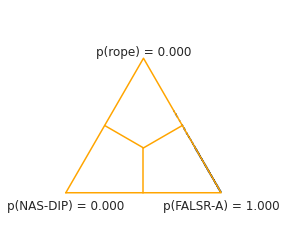

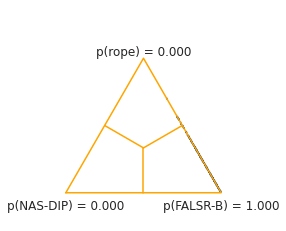

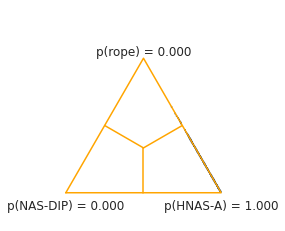

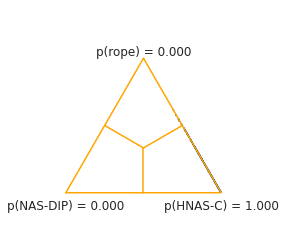

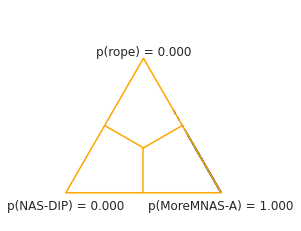

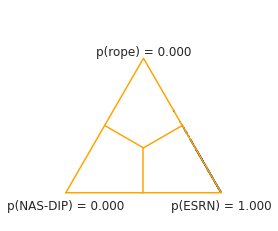

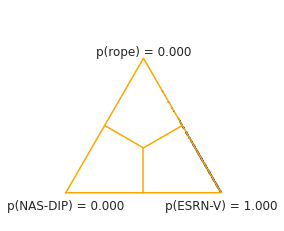

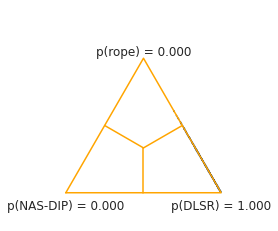

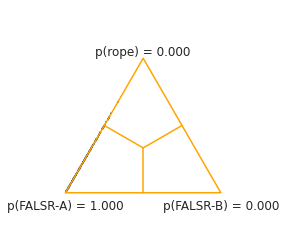

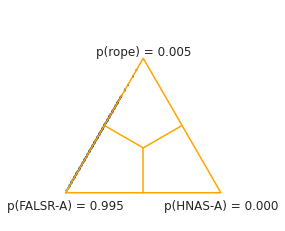

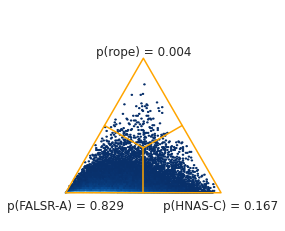

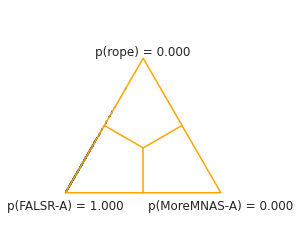

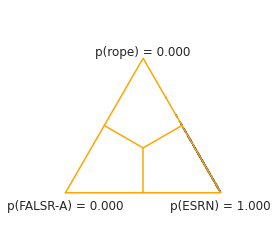

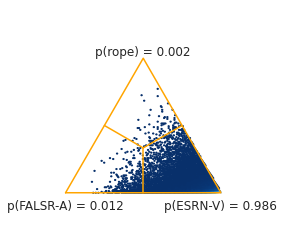

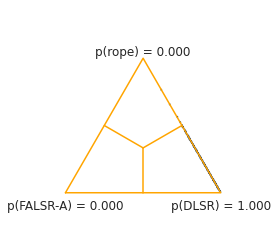

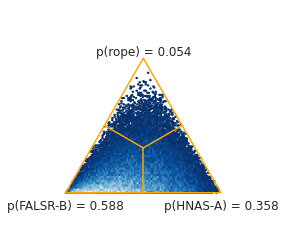

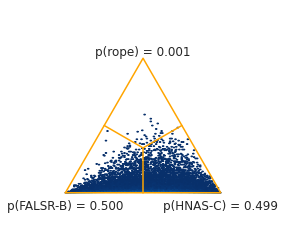

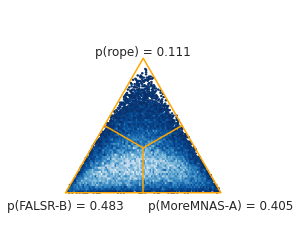

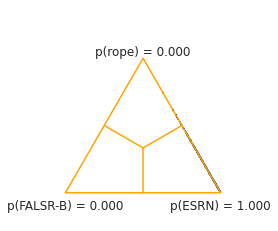

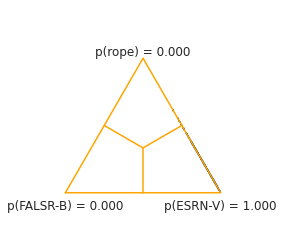

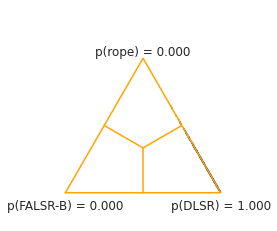

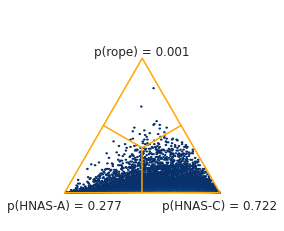

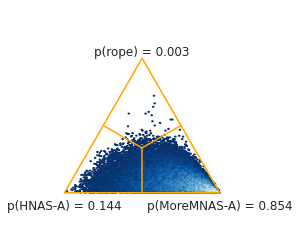

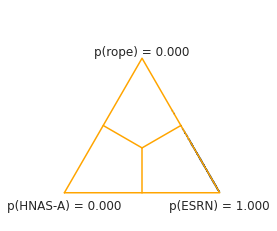

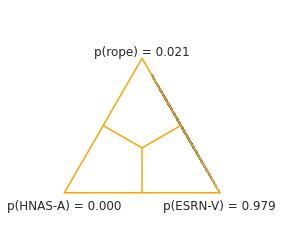

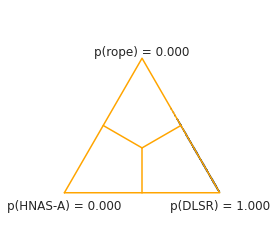

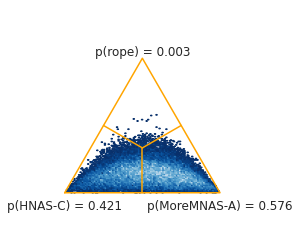

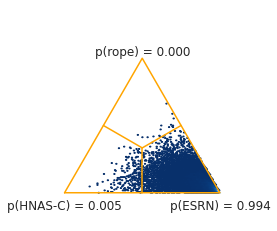

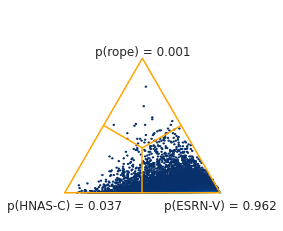

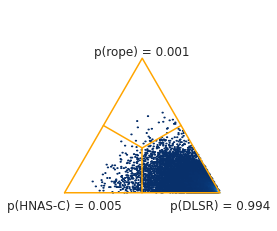

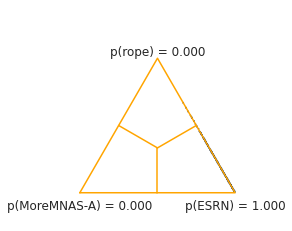

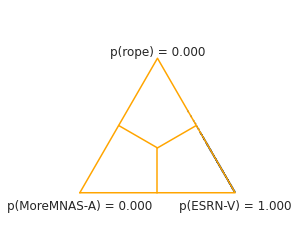

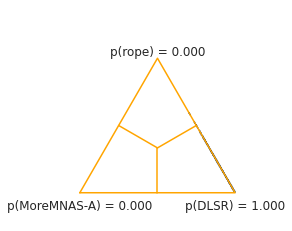

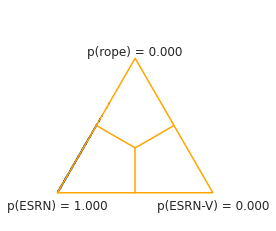

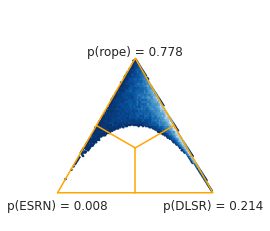

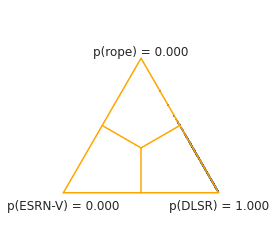

In [17]:
with open('posterior_probabilities.txt', 'w') as fp:
  for i in range(0,len(names)):
    for j in range(i+1,len(names)):
      probs, fig = bc.two_on_multiple(df_normalized[names[i]], df_normalized[names[j]], rope=0.01, plot=True, names=[names[i],names[j]])
      fp.write(f"[{names[i]}],[{names[j]}], {probs}\n")
      fig.savefig(f"/content/Images/{i}-{j}.png")
fp.close

In [20]:
from google.colab import files
import os

dir_to_zip = '/content/Images' #@param {type: "string"}
output_visuals = 'Bayesian_Comp.zip' #@param {type: "string"}
output_probabilities = 'posterior_probabilities.txt' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_visuals )
files.download( output_probabilities )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>